# Data is provided by Johns Hopkins University
Source code is on Github
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 


In [3]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-08-2020.csv')

In [4]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,766,773,782,789,795,803,820,832,842,850
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,743,745,745,747,748,750,751,751,752,752
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,27,27,30,35,35,35,36,36,36,43


In [5]:
cols = confirmed_df.keys()

In [6]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [7]:
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20
0,0,0,0,0,0,0,0,0,0,0,...,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778
1,0,0,0,0,0,0,0,0,0,0,...,766,773,782,789,795,803,820,832,842,850
2,0,0,0,0,0,0,0,0,0,0,...,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369
3,0,0,0,0,0,0,0,0,0,0,...,743,745,745,747,748,750,751,751,752,752
4,0,0,0,0,0,0,0,0,0,0,...,27,27,30,35,35,35,36,36,36,43


In [8]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

china_cases = [] 
italy_cases = []
us_cases = [] 
india_cases = [] 


china_deaths = [] 
italy_deaths = []
us_deaths = [] 
india_deaths = [] 


china_recoveries = [] 
italy_recoveries = []
us_recoveries = [] 
india_recoveries = [] 


for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    india_cases.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    
    
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    india_deaths.append(confirmed_df[deaths_df['Country/Region']=='India'][i].sum())
    
    
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    india_recoveries.append(recoveries_df[confirmed_df['Country/Region']=='India'][i].sum())
    

C:\Users\Meenal\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [9]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

In [10]:
# confirmed cases
world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
india_daily_increase = daily_increase(india_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
china_daily_death = daily_increase(china_deaths)
italy_daily_death = daily_increase(italy_deaths)
us_daily_death = daily_increase(us_deaths)
india_daily_death = daily_increase(india_deaths)


# recoveries
world_daily_recovery = daily_increase(total_recovered)
china_daily_recovery = daily_increase(china_recoveries)
italy_daily_recovery = daily_increase(italy_recoveries)
us_daily_recovery = daily_increase(us_recoveries)
india_daily_recovery = daily_increase(india_recoveries)

In [11]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [12]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
india_cases = np.array(india_cases).reshape(-1, 1)
india_deaths = np.array(india_deaths).reshape(-1, 1)
india_recovered = np.array(india_recoveries).reshape(-1, 1)

# Prediction

In [16]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [17]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [18]:
#dividing dataset into test and train
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.36, shuffle=False) 

In [19]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

C:\Users\Meenal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 779471.4523100877
MSE: 647176153834.2794


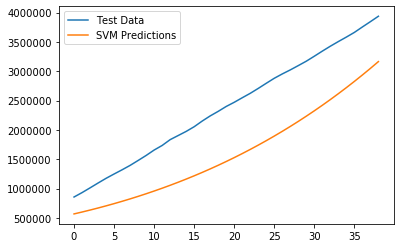

In [20]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [24]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

In [25]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 313743.79212126916
MSE: 172891942210.34283


In [26]:
print(linear_model.coef_)

[[-6.55764098e+04  1.77040430e+04 -7.48955408e+02  9.62586478e+00]]


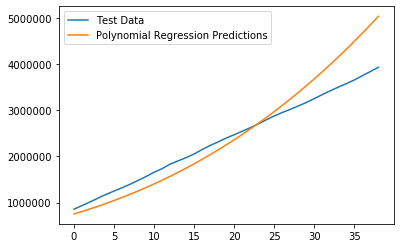

In [27]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [54]:
# Predictions for confirmed coronavirus cases worldwide
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.scatter(x, y)
    plt.scatter(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

         Date  SVM Predicted # of Confirmed Cases Worldwide
0  05/09/2020                                     3284151.0
1  05/10/2020                                     3406483.0
2  05/11/2020                                     3532228.0
3  05/12/2020                                     3661450.0
4  05/13/2020                                     3794212.0
5  05/14/2020                                     3930578.0
6  05/15/2020                                     4070613.0
7  05/16/2020                                     4214382.0
8  05/17/2020                                     4361951.0
9  05/18/2020                                     4513386.0


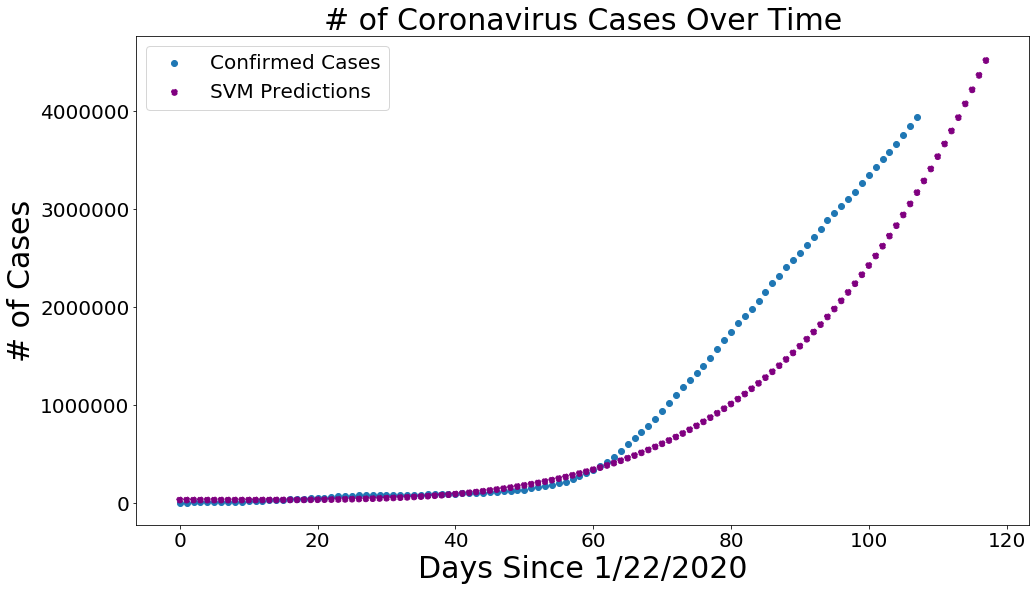

In [55]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
print(svm_df)
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

         Date  Polynomial Predicted # of Confirmed Cases Worldwide
0  05/09/2020                                          5236462.0  
1  05/10/2020                                          5431599.0  
2  05/11/2020                                          5631534.0  
3  05/12/2020                                          5836324.0  
4  05/13/2020                                          6046027.0  
5  05/14/2020                                          6260700.0  
6  05/15/2020                                          6480402.0  
7  05/16/2020                                          6705190.0  
8  05/17/2020                                          6935122.0  
9  05/18/2020                                          7170256.0  


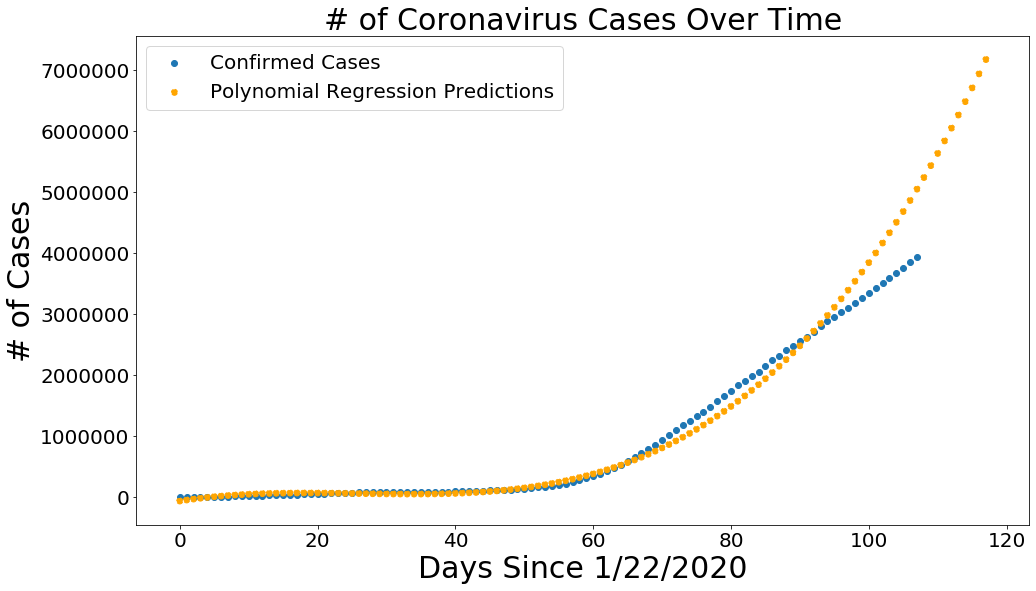

In [56]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
print(svm_df)
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

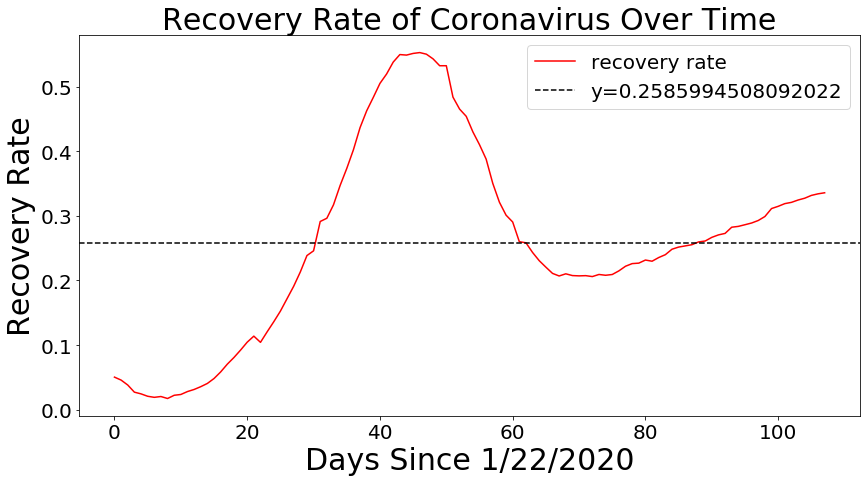

In [58]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(14, 7))
plt.plot(adjusted_dates, recovery_rate, color='red')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [65]:
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(20,10))
    
    plt.subplot(221)
    plt.plot(x, y1)
    plt.title('{} Confirmed Cases'.format(country), size=20)
    plt.xlabel('Days Since 1/22/2020', size=10)
    plt.ylabel('# of Cases', size=10)
    plt.xticks(size=10)
    plt.yticks(size=10)
    
    plt.subplot(222)
    plt.plot(x, y2) 
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=20)
    plt.xlabel('Days Since 1/22/2020', size=10)
    plt.ylabel('# of Cases', size=10)
    plt.xticks(size=10)
    plt.yticks(size=10)
    
    plt.subplot(223)
    plt.plot(x, y3)
    plt.title('{} Daily Increases in Deaths'.format(country), size=20)
    plt.xlabel('Days Since 1/22/2020', size=10)
    plt.ylabel('# of Cases', size=10)
    plt.xticks(size=10)
    plt.yticks(size=10)
    
    plt.subplot(224)
    plt.plot(x, y4)
    plt.title('{} Daily Increases in Recoveries'.format(country), size=20)
    plt.xlabel('Days Since 1/22/2020', size=10)
    plt.ylabel('# of Cases', size=10)
    plt.xticks(size=10)
    plt.yticks(size=10)
    
    plt.show()


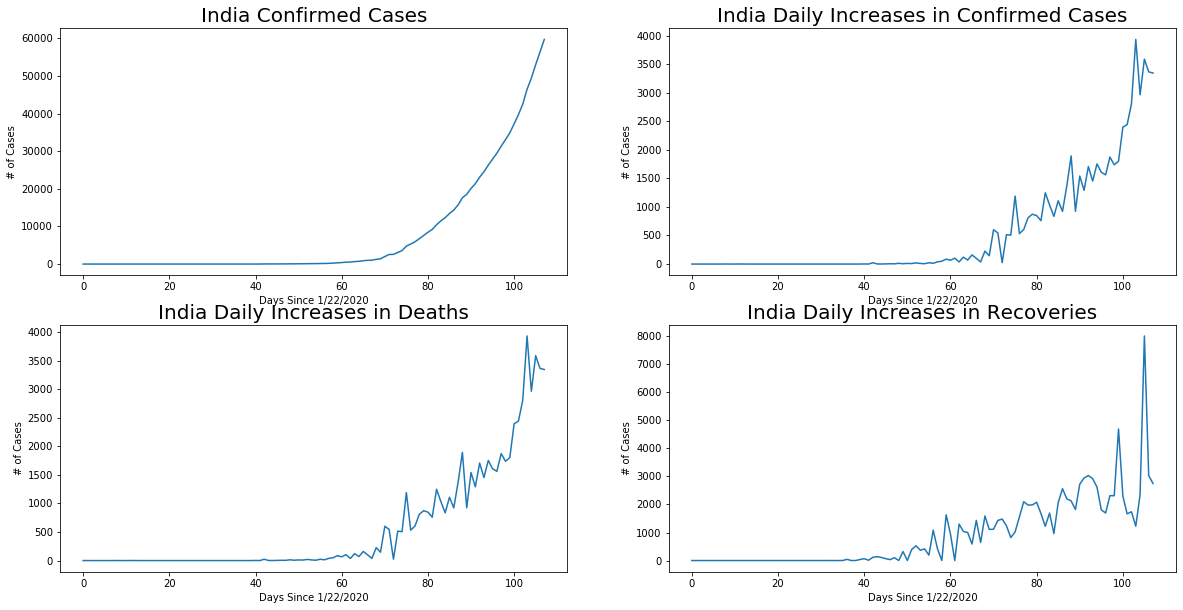

In [66]:
country_plot(adjusted_dates, india_cases, india_daily_increase, india_daily_death, india_daily_recovery, 'India')